# Building a Better Board Game

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
print("Matplotlib version {} is installed.").format(matplotlib.__version__)
# Style 'ggplot' makes prettier plots.
# (plt.style isn't supported before matplotlib v1.4)
# Comment the following line, and this notebook will
# still run on matplotlib <1.4, but with default plot styling.
plt.style.use('ggplot')

Matplotlib version 1.5.1 is installed.


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data Exploration / Data Preprocessing

Read all of our data in as a pandas data frame

In [2]:
allData = pd.read_csv("../Data/CSV/games.csv")

How many observations (games) are in our set?

In [3]:
print("The data set contains {} games.").format(len(allData))

The data set contains 84593 games.


Get an idea of the range of values for each feature in the data

In [4]:
allData.describe()

/usr/lib/python2.7/dist-packages/pandas/compat/scipy.py:68: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  score = values[idx]


,id,year,ratingScore,ratingCount,ratingStdDev,weightAvg,weightLightPct,weightMediumLightPct,weightMediumPct,weightMediumHeavyPct,weightHeavyPct,playerAgeMin,playtimeMin,playtimeMax,playersStatedMin,playersStatedMax,playersBestMin,playersBestMax,priceAverage,priceStdDev,
count,84593.000000,84593.000000,84593.000000,84593.000000,84593.000000,84593.000000,71714.000000,71714.000000,71714.000000,71714.000000,71714.000000,84593.000000,84593.000000,84593.000000,84593.00000,84593.000000,84593.000000,84593.000000,19461.000000,19461.000000,...
mean,80013.233152,1807.385008,4.279174,110.736988,0.774242,0.876848,19.957703,16.550744,10.183793,3.200719,1.401069,7.019162,47.198243,51.168395,1.98825,5.682491,2.219664,5.263934,24.716603,7.954304,...
std,63960.226532,588.475029,3.039157,929.482652,0.814887,1.160127,35.385330,29.738281,23.392949,12.743502,8.428136,6.808049,327.225953,341.891784,0.92677,55.144456,1.210552,54.600688,33.740133,16.690697,...
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.010000,0.000000,...
25%,23001.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000,2.00000,2.000000,2.000000,2.000000,9.950000,0.000000,...
50%,60049.000000,2004.000000,5.333330,2.000000,0.695211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,30.000000,30.000000,2.00000,4.000000,2.000000,4.000000,16.663333,3.925003,...
75%,139950.000000,2011.000000,6.716100,15.000000,1.419710,1.785700,25.000000,25.000000,0.000000,0.000000,0.000000,12.000000,60.000000,60.000000,2.00000,6.000000,2.000000,6.000000,29.084300,9.479418,...
max,202858.000000,2018.000000,10.000000,59423.000000,4.500000,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1333.000000,60120.000000,60120.000000,99.00000,11299.000000,99.000000,11299.000000,1300.000000,581.085046,...


It seems that most features have values for most games, with the exception of priceAverage and priceStdDev

In [5]:
feature = "priceAverage"
percentage = len(allData[feature].dropna())/float(len(allData)) * 100
print("{:.3f}% of games have a value for the '{}' feature.").format(percentage, feature)

23.005% of games have a value for the 'priceAverage' feature.


How many games have values for *all* features in the set?

In [6]:
allWithoutNA = allData.dropna()
percentage = len(allWithoutNA)/float(len(allData)) * 100
print("{:.3f}% of games have a values for all features.").format(percentage, feature)
print("{} games remain once filtering out those with null feature values.").format(len(allWithoutNA))

22.573% of games have a values for all features.
19095 games remain once filtering out those with null feature values.


Some games have feature values that we might choose to consider as outliers.

In [7]:
allWithoutNA.year.describe()

count    19095.000000
mean      1980.718408
std        209.432133
min      -3500.000000
25%       1994.000000
50%       2006.000000
75%       2012.000000
max       2016.000000
Name: year, dtype: float64

As you can see above, some games were published as early as 3500 B.C.
Perhaps we should limit the year of publication to exclude ancient Egyptian games.

In [8]:
since1950 = allWithoutNA.query("year >= 1950")
print("{} games remain once filtering out those published prior to 1950.").format(len(since1950))

18799 games remain once filtering out those published prior to 1950.


Ratings are crowd-sourced. Ratings may be less reliable if there were too few people contributing to the rating.

How many games have at least three votes cast toward their rating?

In [9]:
atLeastThreeRaters = since1950.query("ratingCount > 2")
print("{} games remain once filtering out those rated by fewer than 3 people").format(len(atLeastThreeRaters))

18141 games remain once filtering out those rated by fewer than 3 people


Our target variable is going to be 'ratingScore'.

Let's see how the ratingScore value is distributed.

In [10]:
df = atLeastThreeRaters
df.ratingScore.describe()

count    18141.000000
mean         6.496881
std          1.022268
min          1.000000
25%          5.857140
50%          6.546350
75%          7.217780
max         10.000000
Name: ratingScore, dtype: float64

It seems as if 1.0 is the minimum allowable score, and 10.0 is the max.

A histogram will probably help us see how these ratings are distributed.

## Exploratory Visualization

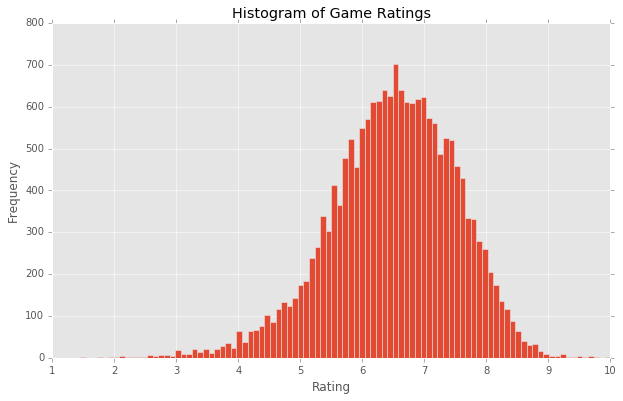

In [11]:
plt.figure(figsize=(10,6))
plt.hist(df.ratingScore, 100)
plt.xlim(xmin=1, xmax=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Game Ratings")
plt.show()

Well, that looks like a skewed Gaussian distribution. Ratings of 1.0 and 10.0 are quite uncommon.

The mean of our subset of the data is shifted toward higher ratings.

In [12]:
print "The mean rating for our subset of games is {:.3f}.".format(np.mean(df.ratingScore))

The mean rating for our subset of games is 6.497.


Now let's separate the columns that we intend to use as features from that which is the target.

In [13]:
# Why are we excluding features?
# 'id' holds no predictive value
# 'name', and 'url' are strings, and cannot be features in their current form
# 'ratingCount' and 'ratingStdDev' will likely be unavailable features during prediction
# 'ratingScore' is the target variable, and should not be used to train a model
excluded = ["id", "name", "url", "ratingScore", "ratingCount", "ratingStdDev"]
feature_cols = [col for col in df.columns if col not in excluded]

# This is our target
target_col = "ratingScore"

# Create an n*m data frame where n is the number of games, and m is the number of features
X_all = df[feature_cols]
# Create an n*1 data frame where n is the number of games, each with the single target feature
y_all = df[target_col]

## Implementation

We need to split this data into (at least) two portions.
* A training set - 80% of total
 * 70% of which will be 10-fold cross-validated when fed to child regressors.
 * 30% of which will be 10-fold cross-validated when fed to parent stacker.
* A held-out test (or validation) set - 20% of total

In [112]:
# Select features (X) and corresponding labels (y) for the trainingCV and holdout sets
# train_test_split() shuffles data randomly. We will set the random state for consistency
from sklearn.cross_validation import train_test_split
# X/y_train are 80% of data, for use in training/testing models.
# X/y_holdout are 20% of data, for use in proving model performance at the end.
X_train, X_holdout, y_train, y_holdout = train_test_split(
    np.array(X_all), np.array(y_all),
    train_size=0.8,
    random_state=12)

from sklearn.cross_validation import KFold
# We will split X_train into train and test 10 times via KFold
kf = KFold(len(X_base), n_folds=10, shuffle=True, random_state=12)

print "Cross-validated Training set includes {} samples".format(len(X_train))
print "Holdout/Validation set includes       {} samples".format(len(X_holdout))

Cross-validated Training set includes 14512 samples
Holdout/Validation set includes       3629 samples


With random sampling, we would anticipate the histogram of the target variable in the training and test sets to be similarly distributed.

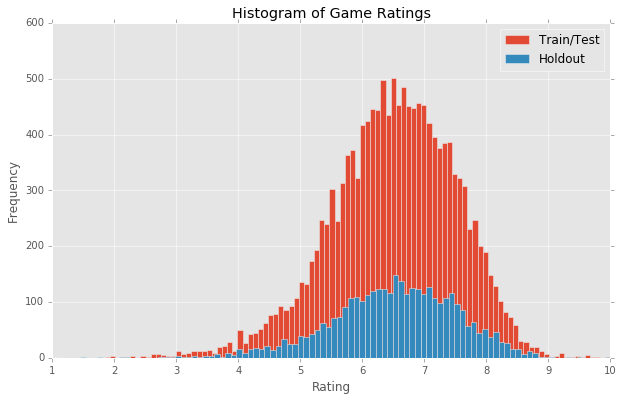

In [113]:
plt.figure(figsize=(10,6))
plt.hist(y_train, 100, label="Train/Test")
plt.hist(y_holdout, 100, label="Holdout")
plt.legend(loc='upper right')
plt.xlim(xmin=1, xmax=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Game Ratings")
plt.show()

In [114]:
# Helper functions to train and predict
import time
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from sklearn.grid_search import GridSearchCV

def train(learner, X_train, y_train):
    print "Training {}...".format(learner.__class__.__name__)
    start = time.time()
    learner.fit(X_train, y_train)
    end = time.time()
    print "Done.\nTraining time (secs): {:.3f}".format(end - start)
    
def predict(learner, features):
    print "Predicting target using {}...".format(learner.__class__.__name__)
    start = time.time()
    y_pred = learner.predict(features)
    end = time.time()
    print "Done.\nPrediction time (secs): {:.3f}".format(end - start)
    return pd.Series(y_pred)

### Random Forest regressor

We'll use GridSearchCV to learn what the best choices for parameters might be.

In [118]:
# Random Forest is a tree-based learner.
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor(
    n_estimators=2000,
    oob_score=True,
    random_state=12)
# We'll mess with some parameters in our grid search.
# A smart choice for max_features is sqrt(num_features).
# For our 159 features, that would be 12.6, so I'm starting in that range.
parameters = {
    'max_features': np.arange(10,150,10),
    'min_samples_split': np.arange(2,11,1)
}
# We'll use MSE as our function to determine the winner in the grid search
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# Set up the grid search, using "base" data in 10 folds
rf_grid = GridSearchCV(random_forest_reg, parameters, scoring=mse_scorer, cv=kf)

In [119]:
# Fit model to training data - this will take a while.
train(rf_grid, X_train, y_train)

Training GridSearchCV...
Done.
Training time (secs): 130960.451


What were the best values for the hyper-parameter(s) within our grid?

In [120]:
# Let's print which parameter(s) were chosen as the best in the grid
print "\nBest model: {}".format(rf_grid.best_estimator_)


Best model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=40, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=1, oob_score=True, random_state=12,
           verbose=0, warm_start=False)


It might help to visualize the value from the scorer function across the parameter grid.

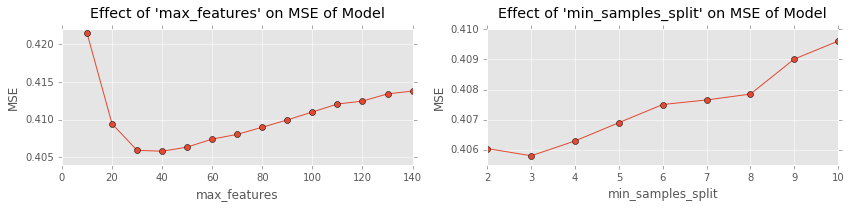

In [131]:
# Subset the grid_scores_ list to isolate one dependent variable
f, (max_features, min_samples_split) = plt.subplots(1, 2, figsize=(12, 3))

# First plot 'max_features'
models = zip(*[(abs(mean), std, p['max_features']) 
    for p, mean, std in [x for x in rf_grid.grid_scores_ if x[0]['min_samples_split'] == 3]])
max_features.plot(models[2],models[0],'o-')
max_features.set_title("Effect of 'max_features' on MSE of Model", y=1.05)
max_features.set_xlabel("max_features")
max_features.set_ylabel("MSE")

# then plot 'min_samples_split'
models = zip(*[(abs(mean), std, p['min_samples_split']) 
    for p, mean, std in [x for x in rf_grid.grid_scores_ if x[0]['max_features'] == 40]])
min_samples_split.plot(models[2],models[0],'o-')
min_samples_split.set_title("Effect of 'min_samples_split' on MSE of Model", y=1.05)
min_samples_split.set_xlabel("min_samples_split")
min_samples_split.set_ylabel("MSE")
f.tight_layout(h_pad=10.05)
f.show()

* 'max_features' seems to produce a models with the lowest mean squared error between 20 and 40 features.
* 'min_samples_split' clearly seems to perform best just above its default value of 2.

Get Random Forest predictions on all the training data now that we've determined good parameter values.

In [162]:
from sklearn.cross_validation import cross_val_predict
# Set the best parameters as our choices for this run.
random_forest_reg.set_params(**rf_grid.best_params_)
# Compute predictions on the entire set by collecting the predictions on the held-out set from each fold
y_rf_pred = cross_val_predict(random_forest_reg, X_train, y_train)
print "Mean Squared Error:  {}".format(mean_squared_error(y_train, y_rf_pred))
print "Pearson Correlation: {}".format(pearsonr(y_train, y_rf_pred)[0])

Mean Squared Error:  0.403008850271
Pearson Correlation: 0.784172030652


Then let's visualize the actual vs predicted ratingScore, to see how close to the diagonal they are.

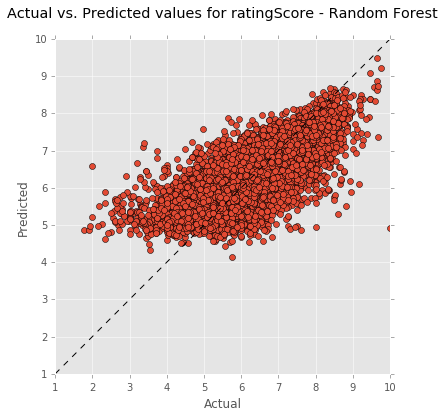

In [163]:
plt.figure(figsize=(6,6))
plt.plot(y_train, y_rf_pred, 'o')
plt.plot([1, 10], [1, 10], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values for ratingScore - Random Forest", y=1.05)
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### K-Nearest-Neighbors

In [138]:
from sklearn.neighbors import KNeighborsRegressor
k_neighbors_reg = KNeighborsRegressor( weights='distance' )
# We'll mess with some parameters in our grid search.
# n_neighbors is now many neighbors to consider for each point
# leaf_size is passed to BallTree/KDTree
parameters = {
    'n_neighbors': np.arange(2,32,2),
    'leaf_size': np.arange(5,55,5)
}
# We'll use MSE as our function to determine the winner in the grid search
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# Set up the grid search, using "base" data in 10 folds
knn_grid = GridSearchCV(k_neighbors_reg, parameters, scoring=mse_scorer, cv=kf)
# Fit model to training data
train(knn_grid, X_train, y_train)

Training GridSearchCV...
Done.
Training time (secs): 1424.307


What were the best values for the hyper-parameter(s) within our grid?

In [139]:
# Let's print which parameter(s) were chosen as the best in the grid
print "\nBest model: {}".format(knn_grid.best_estimator_)


Best model: KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=16, p=2,
          weights='distance')


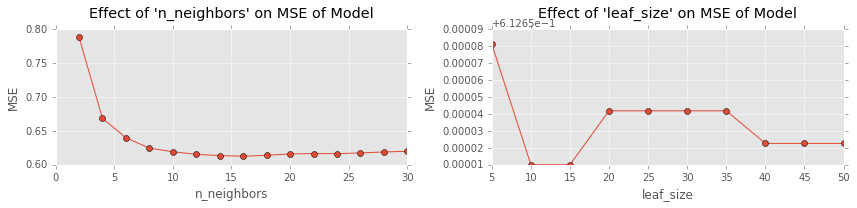

In [142]:
# Subset the grid_scores_ list to isolate one dependent variable
f, (n_neighbors, leaf_size) = plt.subplots(1, 2, figsize=(12, 3))

# First plot 'n_neighbors'
models = zip(*[(abs(mean), std, p['n_neighbors']) 
    for p, mean, std in [x for x in knn_grid.grid_scores_ if x[0]['leaf_size'] == 10]])
n_neighbors.plot(models[2],models[0],'o-')
n_neighbors.set_title("Effect of 'n_neighbors' on MSE of Model", y=1.05)
n_neighbors.set_xlabel("n_neighbors")
n_neighbors.set_ylabel("MSE")

# then plot 'min_samples_split'
models = zip(*[(abs(mean), std, p['leaf_size']) 
    for p, mean, std in [x for x in knn_grid.grid_scores_ if x[0]['n_neighbors'] == 16]])
leaf_size.plot(models[2],models[0],'o-')
leaf_size.set_title("Effect of 'leaf_size' on MSE of Model", y=1.05)
leaf_size.set_xlabel("leaf_size")
leaf_size.set_ylabel("MSE")
f.tight_layout(h_pad=10.05)
f.show()

* n_neighbors had an clear impact the resulting model's mean squared error. **16 Seemed to be a good value** (though not by much)
* leaf_size had nearly no impact (note the scale). It's probably not a parameter I should have messed with. **I'll use the default of 30 in the future.**

Get K Neighbor predictions on all the training data now that we've determined good parameter values.

In [164]:
# Set the best parameters as our choices for this run.
k_neighbors_reg.set_params(**knn_grid.best_params_)
# Compute predictions on the entire set by collecting the predictions on the held-out set from each fold
y_knn_pred = cross_val_predict(k_neighbors_reg, X_train, y_train)
print "Mean Squared Error:  {}".format(mean_squared_error(y_train, y_knn_pred))
print "Pearson Correlation: {}".format(pearsonr(y_train, y_knn_pred)[0])

Mean Squared Error:  0.621203101008
Pearson Correlation: 0.634370414196


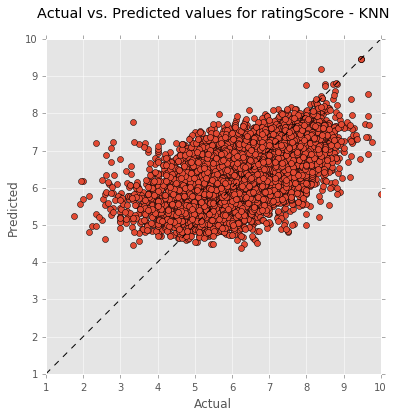

In [165]:
plt.figure(figsize=(6,6))
plt.plot(y_train, y_knn_pred, 'o')
plt.plot([1, 10], [1, 10], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values for ratingScore - KNN", y=1.05)
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Support Vector regressor

In [173]:
# The Support Vector Machine (SVM) as a regression is referred to as SVR.
from sklearn.svm import SVR
support_vector_reg = SVR()
# We'll mess with some parameters in our grid search.
# C - Penalty parameter (1/lambda)
# epsilon - Allowable error
parameters = {
    'C':       [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]
}
# Set up the GridSearch with cross-validation
svr_grid = GridSearchCV(support_vector_reg, parameters, scoring=mse_scorer, cv=kf)

In [174]:
# Fit model to training data
train(svr_grid, X_train, y_train)

Training GridSearchCV...
Done.
Training time (secs): 9773.362


What were the best values for the hyper-parameter(s) within our grid?

In [176]:
# Let's print which parameter(s) were chosen as the best in the grid
print "Best model: {}".format(svr_grid.best_estimator_)

Best model: SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


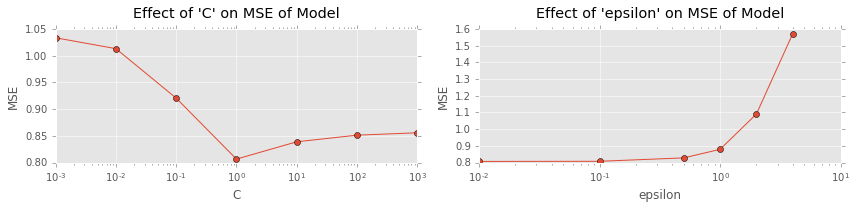

In [181]:
# Subset the grid_scores_ list to isolate one dependent variable
f, (C, epsilon) = plt.subplots(1, 2, figsize=(12, 3))

# First plot 'C'
models = zip(*[(abs(mean), std, p['C']) 
    for p, mean, std in [x for x in svr_grid.grid_scores_ if x[0]['epsilon'] == 0]])
C.semilogx(models[2],models[0],'o-')
C.set_title("Effect of 'C' on MSE of Model", y=1.05)
C.set_xlabel("C")
C.set_ylabel("MSE")

# then plot 'epsilon'
models = zip(*[(abs(mean), std, p['epsilon']) 
    for p, mean, std in [x for x in svr_grid.grid_scores_ if x[0]['C'] == 1]])
epsilon.semilogx(models[2],models[0],'o-')
epsilon.set_title("Effect of 'epsilon' on MSE of Model", y=1.05)
epsilon.set_xlabel("epsilon")
epsilon.set_ylabel("MSE")
f.tight_layout(h_pad=10.05)
f.show()

Get Support Vector predictions on all the training data now that we've determined good parameter values.

In [182]:
# Set the best parameters as our choices for this run.
support_vector_reg.set_params(**svr_grid.best_params_)
# Compute predictions on the entire set by collecting the predictions on the held-out set from each fold
y_svr_pred = cross_val_predict(support_vector_reg, X_train, y_train)
print "Mean Squared Error:  {}".format(mean_squared_error(y_train, y_svr_pred))
print "Pearson Correlation: {}".format(pearsonr(y_train, y_svr_pred)[0])

Mean Squared Error:  0.808911846634
Pearson Correlation: 0.47562124906


Let's again visualize the actual vs predicted ratingScore

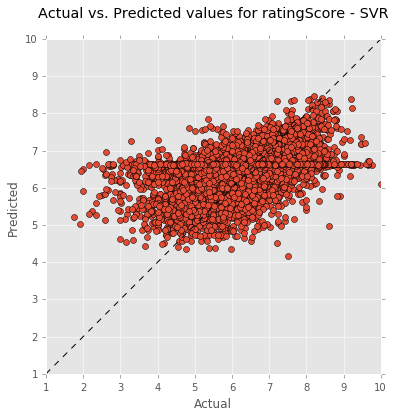

In [183]:
plt.figure(figsize=(6,6))
plt.plot(y_train, y_svr_pred, 'o')
plt.plot([1, 10], [1, 10], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values for ratingScore - SVR", y=1.05)
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Gradient Boosting Regressor

What if we stacked these two learners together to create another model?

In [188]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boost_reg = GradientBoostingRegressor(
    max_features='sqrt',
    random_state=12)
# We'll mess with one parameter in our grid search. (GBR takes a long time)
# max_depth - How far to grow each of the trees
parameters = {
    'max_depth': [2, 3, 4, 6, 8, 10, 20]
}
# Set up the GridSearch with cross-validation
gbr_grid = GridSearchCV(gradient_boost_reg, parameters, scoring=mse_scorer, cv=kf)

In [ ]:
# Fit model to training data - not nearly as long-running as RandomForest
train(svr_grid, X_train, y_train)

What were the best values for the hyper-parameter(s) within our grid?

In [175]:
print "Best model: {}".format(gbr_grid.best_estimator_)

NameError: name 'gbr_grid' is not defined

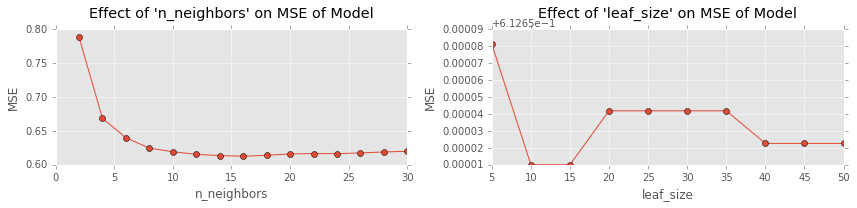

In [142]:
# Plot 'max_depth' vs MSE
models = zip(*[(abs(mean), std, p['n_neighbors']) for p, mean, std in knn_grid.grid_scores_])
plt.plot(models[2],models[0],'o-')
plt.set_title("Effect of 'n_neighbors' on MSE of Model", y=1.05)
plt.set_xlabel("n_neighbors")
plt.set_ylabel("MSE")
plt.show()

In [71]:
# Linear regression will be used to stack the children models.
from sklearn.linear_model import  LinearRegression
linear_reg = LinearRegression(normalize=True)

# Create a data frame with each child learner's predictions as a column
child_predictions = pd.DataFrame()
child_predictions['random_forest']     = pd.Series(y_rf_pred)
child_predictions['k_neighbors']       = pd.Series(y_knn_pred)
child_predictions['support_vector']    = pd.Series(y_svr_pred)
child_predictions['gradient_boosting'] = pd.Series(y_gbr_pred)

# Train the stacked regression
y_stack_pred = cross_val_predict(linear_reg, child_predictions, y_train)

In [72]:
train(linear_reg, child_predictions, y_train)

Training LinearRegression...
Done.
Training time (secs): 0.001


In [73]:
# How did the stack of two child models perform?
print "Mean Squared Error:  {}".format(mean_squared_error(y_stack, y_stack_pred))
print "Pearson Correlation: {}".format(pearsonr(y_stack, y_stack_pred)[0])

Mean Squared Error:  0.421879743474
Pearson Correlation: 0.778242514765


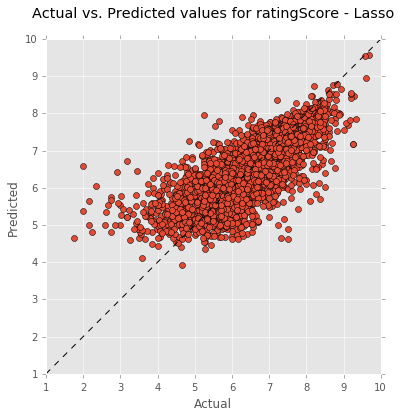

In [111]:
plt.figure(figsize=(6,6))
plt.plot(y_stack, y_stack_pred, 'o')
plt.plot([1, 10], [1, 10], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values for ratingScore - Lasso", y=1.05)
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Creating a Pipeline for Stacking

This is a bit tedious. It'd be easier if this stacking concept had a standard interface.

In [185]:
class StackedRegression:
    from joblib import Parallel, delayed
    from sklearn.metrics import make_scorer, mean_squared_error
    from scipy.stats import pearsonr
    from sklearn.cross_validation import cross_val_predict

    __name__ = 'StackedRegression'
    
    def __init__(self, estimators, meta_estimator, cv=None, random_state=None, n_jobs=1, verbose=0):
        self.estimators = estimators
        self.meta_estimator = meta_estimator
        self.cv = cv
        self.random_state = random_state
        self.verbose = verbose
    
    def _fit_estimator(estimator, X, y, cv=10, verbose=0, random_state=None):
        """Private function used to fit with a single estimator in parallel."""
        # Get cross-validated predictions on all of the data - to feed to stacker
        y_pred = cross_val_predict(estimator, X, y, cv=10)
        if verbose > 0:
            print "Estimator: {}".format(estimator.__name__)
            print "  Mean Squared Error:  {}".format(mean_squared_error(y, y_pred))
            print "  Pearson Correlation: {}".format(pearsonr(y, y_pred)[0])
        # Train the final estimator on all data
        estimator.fit(X, y)
        # Return the cross-validated predictions for this child estimator
        return y_pred

    def _predict_estimator(estimator, X, verbose=0):
        """Private function used to predict with a single estimator in parallel."""
        # Return the cross-validated predictions for this child estimator
        return estimator.predict(X)

    def fit(self, X, y):
        """Fit the model according to the given training data."""
        # Parallel loop: fit each estimator, storing cross-validated predictions
        self.child_predictions_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
            backend="threading")(
                delayed(_fit_estimator)(
                    est, X, y, cv=self.cv, verbose=self.verbose, random_state=self.random_state)
                for est in estimators)
        # fit the meta-estimator on the predictions from the child estimators
        self.stack_pred_ = _fit_estimator(self.meta_estimator,
            self.child_predictions_, y, cv=self.cv, verbose=self.verbose, random_state=self.random_state)
        return self
    
    def predict(self, X):
        """Predict class for X."""
        # First predict with all child estimators
        # Parallel loop: predict with each child estimator
        child_predictions = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
            backend="threading")(
                delayed(_predict_estimator)(est, X, verbose=self.verbose)
                for est in estimators)
        # fit the meta-estimator on the predictions from the child estimators
        stack_predictions = _predict_estimator(self.meta_estimator, child_predictions, verbose=self.verbose)
        return stack_predictions

In [189]:
# I'll use a linear model (Lasso) as the "meta-estimator" or stacker
from sklearn.linear_model import Lasso
lasso_reg = Lasso()

# Create the stacking regression learner
stacker = StackedRegression(
    # Child estimators
    [random_forest_reg, k_neighbors_reg, support_vector_reg, gradient_boost_reg],
    # Stacking meta-estimator
    lasso_reg,
    cv=kf,
    verbose=1,
    random_state=12,
    n_jobs=4)

## Illustrative Plots for the Paper

### Correlation Coefficients

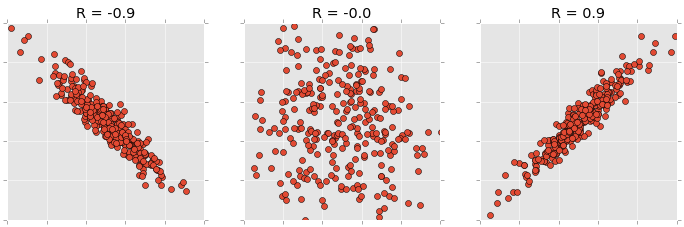

In [186]:
# Settings that apply to all plots
f, (neg, zero, pos) = plt.subplots(1, 3, figsize=(12, 4))
plots = [
    (neg,  [[.03, -.03], [.001, .001]]),  # Negative correlation
    (zero, [[.05, 0],    [0, .05]]),      # Random (near-zero) correlation
    (pos,  [[.03, .03],  [-.001, .001]])] # Positive correlation
for (subplot, covariance) in (plots):
    # Distributions centered around the midpoint between 0 and 1
    mean = [0.5, 0.5]
    x, y = np.random.multivariate_normal(mean, covariance, 300).T
    subplot.set_aspect('equal', adjustable='box')
    subplot.plot(x, y, 'o')
    subplot.set_xlim(0,1)
    subplot.set_ylim(0,1)
    subplot.axes.get_xaxis().set_ticklabels([])
    subplot.axes.get_yaxis().set_ticklabels([])
    subplot.set_title("R = {0:.1f}".format(pearsonr(x, y)[0]))
#Show them all
plt.show()